# Linear Discrimination with SVM (USD/UAH)

Мета: передбачити **напрямок руху курсу USD/UAH** на наступний день за допомогою методу лінійної дискримінації з Support Vector Machine (SVM). Ціль: `y_direction = 1`, якщо курс зросте наступного дня, інакше `0` (падіння або без змін).

## Постановка задачі

- Маємо щоденні ознаки на дні t (технічні індикатори, ковзні середні, волатильність)
- Прогнозуємо бінарну класифікацію: **зросте курс (+) чи впаде (-)** на день t+1
- Використовуємо Linear SVM як метод лінійної дискримінації
- Оцінюємо на часовому поділі: 80% train, 20% test

## Підходи

1. **Sklearn Linear SVM** (з kernel='linear')
2. **Власна реалізація Linear SVM** через primal формулювання з L2-регуляризацією

## Метрики

- Accuracy, Balanced Accuracy, Precision, Recall, F1-score
- ROC-AUC для оцінки якості ранжування
- Confusion Matrix
- Візуалізація decision boundary (для 2D проєкції)

## Особливості

- Обробка незбалансованості класів через `class_weight='balanced'`
- Стандартизація ознак (критично для SVM)
- Інженерія фіч: технічні індикатори, ковзні середні, лагові змінні
- Time-aware split (без leakage з майбутнього)


In [7]:
# Imports
import os
import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, 
    recall_score, f1_score, roc_curve, auc, RocCurveDisplay, 
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

# Plot settings
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (9, 5)

# Paths
ROOT = pathlib.Path(".").resolve()
DATASET_PATHS = [
    ROOT.parent / "datasets" / "USD_UAH Historical Data.csv",
    ROOT / "datasets" / "USD_UAH Historical Data.csv",
]

# Helper to load data
def load_usd_uah(paths):
    for p in paths:
        if p.exists():
            df = pd.read_csv(p)
            return df, p
    raise FileNotFoundError("File 'USD_UAH Historical Data.csv' was not found in known paths.")

raw_df, used_path = load_usd_uah(DATASET_PATHS)
print(f"Loaded data from: {used_path}")
print(f"Dataset shape: {raw_df.shape}")
raw_df.head()


Loaded data from: D:\Study\ро\datasets\USD_UAH Historical Data.csv
Dataset shape: (462, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,10/07/2025,41.4030,41.1503,41.4030,41.1503,NaN,0.25%
1,10/06/2025,41.3000,41.3500,41.4420,41.1880,NaN,-0.12%
2,10/03/2025,41.3500,41.0859,41.3708,41.0455,NaN,0.64%
3,10/02/2025,41.0859,41.2372,41.3520,41.0680,NaN,-0.37%
4,10/01/2025,41.2372,41.1262,41.3353,41.0750,NaN,0.27%


In [8]:
# Data preparation: parse dates, sort, create features and target (direction)

df = raw_df.copy()

# Parse dates in mm/dd/YYYY format and sort
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

# Numeric columns as float
for col in ["Price", "Open", "High", "Low"]:
    # Replace potential commas and cast to float
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(float)
    )

# Parse Change % column
df["change_pct"] = (
    df["Change %"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .astype(float)
) / 100.0

print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# ===== 1. BASIC RETURNS =====
df["return_1d"] = df["Price"].pct_change()
df["return_2d"] = df["Price"].pct_change(2)
df["return_3d"] = df["Price"].pct_change(3)
df["return_5d"] = df["Price"].pct_change(5)

# ===== 2. INTRADAY FEATURES =====
df["range_pct"] = (df["High"] - df["Low"]) / df["Open"].replace(0, np.nan)
df["gap_open"] = df["Open"].pct_change()
df["high_low_ratio"] = df["High"] / df["Low"]
df["close_open_diff"] = (df["Price"] - df["Open"]) / df["Open"]

# ===== 3. MOVING AVERAGES =====
df["ma_5"] = df["Price"].rolling(5, min_periods=3).mean()
df["ma_10"] = df["Price"].rolling(10, min_periods=5).mean()
df["ma_20"] = df["Price"].rolling(20, min_periods=10).mean()

# Distance from MAs
df["dist_ma5"] = (df["Price"] - df["ma_5"]) / df["ma_5"]
df["dist_ma10"] = (df["Price"] - df["ma_10"]) / df["ma_10"]
df["dist_ma20"] = (df["Price"] - df["ma_20"]) / df["ma_20"]

# MA crossovers
df["ma5_ma10_cross"] = df["ma_5"] - df["ma_10"]
df["ma10_ma20_cross"] = df["ma_10"] - df["ma_20"]

# ===== 4. VOLATILITY FEATURES =====
df["rolling_std_5"] = df["return_1d"].rolling(5, min_periods=3).std()
df["rolling_std_10"] = df["return_1d"].rolling(10, min_periods=5).std()
df["rolling_std_20"] = df["return_1d"].rolling(20, min_periods=10).std()

# ATR (Average True Range)
df["tr"] = np.maximum(
    df["High"] - df["Low"],
    np.maximum(
        np.abs(df["High"] - df["Price"].shift(1)),
        np.abs(df["Low"] - df["Price"].shift(1))
    )
)
df["atr_5"] = df["tr"].rolling(5, min_periods=3).mean() / df["Price"]
df["atr_10"] = df["tr"].rolling(10, min_periods=5).mean() / df["Price"]
df["atr_20"] = df["tr"].rolling(20, min_periods=10).mean() / df["Price"]

# ===== 5. MOMENTUM FEATURES =====
# Rate of Change
df["roc_5"] = (df["Price"] - df["Price"].shift(5)) / df["Price"].shift(5)
df["roc_10"] = (df["Price"] - df["Price"].shift(10)) / df["Price"].shift(10)

# RSI (Relative Strength Index) - simplified
delta = df["Price"].diff()
gain = (delta.where(delta > 0, 0)).rolling(14, min_periods=7).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14, min_periods=7).mean()
rs = gain / loss.replace(0, np.nan)
df["rsi_14"] = 100 - (100 / (1 + rs))

# ===== 6. LAGGED FEATURES =====
for lag in [1, 2, 3, 5]:
    df[f"return_lag_{lag}"] = df["return_1d"].shift(lag)
    df[f"volume_change_lag_{lag}"] = df["change_pct"].shift(lag)

# ===== 7. ABSOLUTE VALUES =====
df["abs_return"] = np.abs(df["return_1d"])
df["abs_gap"] = np.abs(df["gap_open"])

# ===== TARGET: DIRECTION (UP=1, DOWN=0) =====
# Target: will the price go UP tomorrow?
df["ret_tomorrow"] = df["Price"].shift(-1) / df["Price"] - 1.0
df["y_direction"] = (df["ret_tomorrow"] > 0).astype(int)

print(f"✓ Created {len([c for c in df.columns if c not in raw_df.columns])} new features")
print(f"✓ Target variable 'y_direction' created")
print(f"  - Class 1 (UP): {df['y_direction'].sum()} days")
print(f"  - Class 0 (DOWN): {(df['y_direction'] == 0).sum()} days")

# Final feature list
feature_cols = [
    # Returns
    "return_1d", "return_2d", "return_3d", "return_5d",
    # Intraday
    "range_pct", "gap_open", "high_low_ratio", "close_open_diff",
    # Moving averages
    "dist_ma5", "dist_ma10", "dist_ma20", "ma5_ma10_cross", "ma10_ma20_cross",
    # Volatility
    "rolling_std_5", "rolling_std_10", "rolling_std_20",
    "atr_5", "atr_10", "atr_20",
    # Momentum
    "roc_5", "roc_10", "rsi_14",
    # Lags
    "return_lag_1", "return_lag_2", "return_lag_3", "return_lag_5",
    "volume_change_lag_1", "volume_change_lag_2", "volume_change_lag_3", "volume_change_lag_5",
    # Absolute
    "abs_return", "abs_gap"
]

use_cols = feature_cols + ["ret_tomorrow", "y_direction"]
df = df.dropna(subset=use_cols).reset_index(drop=True)

X_all = df[feature_cols].values
y_all = df["y_direction"].values

print(f"\n✓ Final dataset: {len(df)} observations, {len(feature_cols)} features")
print(f"✓ Class balance: {y_all.mean():.2%} UP days")
print("\n" + "=" * 60)

df[["Date", "Price", "return_1d", "ret_tomorrow", "y_direction"]].tail(10)


FEATURE ENGINEERING
✓ Created 39 new features
✓ Target variable 'y_direction' created
  - Class 1 (UP): 204 days
  - Class 0 (DOWN): 258 days

✓ Final dataset: 451 observations, 32 features
✓ Class balance: 44.35% UP days



,Date,Price,return_1d,ret_tomorrow,y_direction
441,2025-09-23,41.4189,0.001649,0.000903,1
442,2025-09-24,41.4563,0.000903,0.000815,1
443,2025-09-25,41.4901,0.000815,-0.002996,0
444,2025-09-26,41.3658,-0.002996,-0.002538,0
445,2025-09-29,41.2608,-0.002538,-0.003262,0
446,2025-09-30,41.1262,-0.003262,0.002699,1
447,2025-10-01,41.2372,0.002699,-0.003669,0
448,2025-10-02,41.0859,-0.003669,0.006428,1
449,2025-10-03,41.3500,0.006428,-0.001209,0
450,2025-10-06,41.3000,-0.001209,0.002494,1


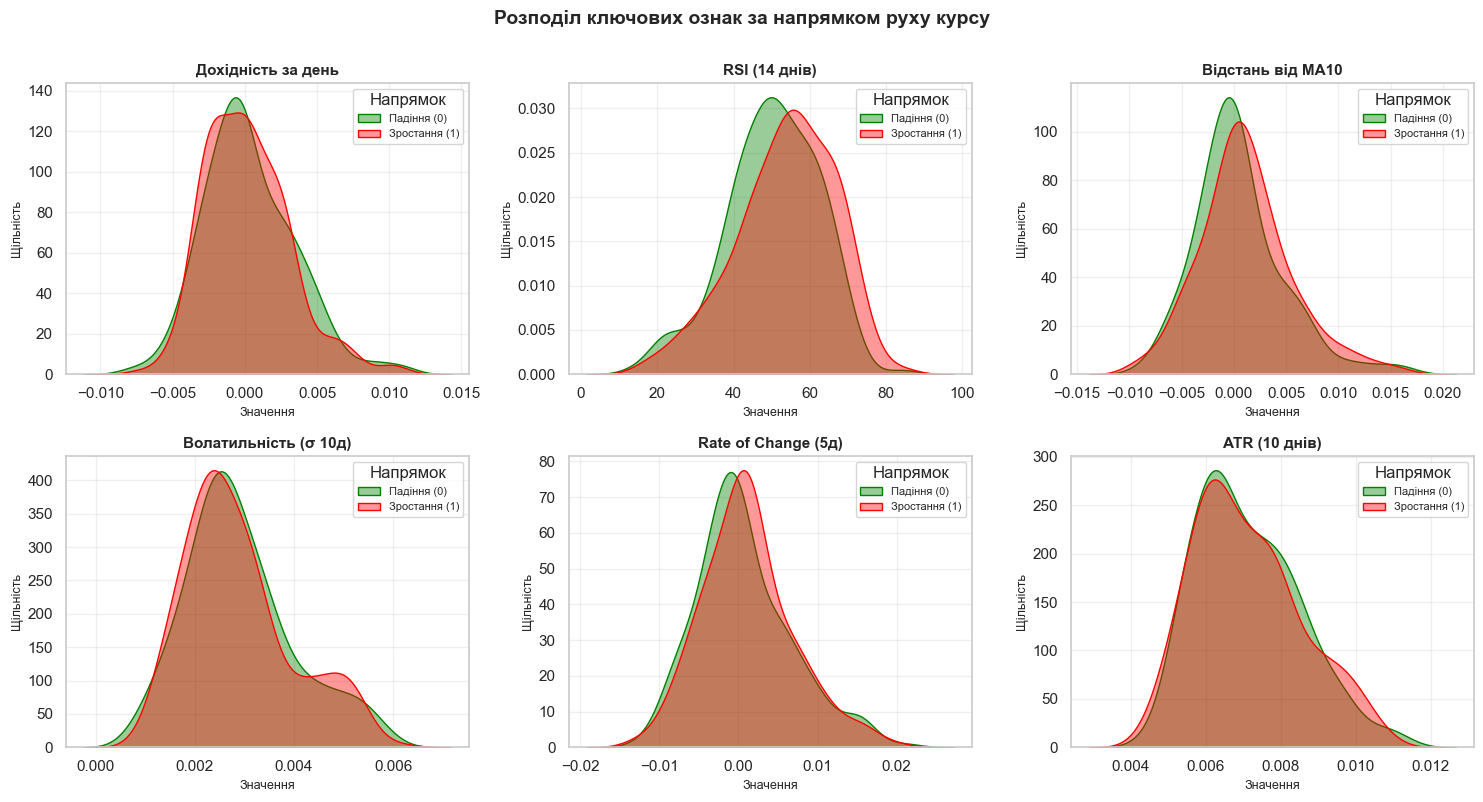

In [9]:
# Exploratory visualization: feature distributions by class

top_features = ["return_1d", "rsi_14", "dist_ma10", "rolling_std_10", "roc_5", "atr_10"]
feature_names_ua = {
    "return_1d": "Дохідність за день",
    "rsi_14": "RSI (14 днів)",
    "dist_ma10": "Відстань від MA10",
    "rolling_std_10": "Волатильність (σ 10д)",
    "roc_5": "Rate of Change (5д)",
    "atr_10": "ATR (10 днів)"
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(top_features):
    ax = axes[i]
    sns.kdeplot(
        data=df, x=col, hue="y_direction", 
        fill=True, common_norm=False, alpha=0.4, ax=ax,
        palette={0: "red", 1: "green"}
    )
    ax.set_title(feature_names_ua[col], fontsize=11, weight='bold')
    ax.set_xlabel("Значення", fontsize=9)
    ax.set_ylabel("Щільність", fontsize=9)
    ax.legend(["Падіння (0)", "Зростання (1)"], title="Напрямок", fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle("Розподіл ключових ознак за напрямком руху курсу", y=1.00, fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


In [10]:
# Time-ordered train/test split + standardization

# Use the first 80% as train, last 20% as test (time-aware)
n = len(X_all)
split_idx = int(n * 0.8)

X_train, y_train = X_all[:split_idx], y_all[:split_idx]
X_test, y_test = X_all[split_idx:], y_all[split_idx:]

print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)
print(f"Train size: {len(X_train)} ({len(X_train)/n:.1%})")
print(f"Test size:  {len(X_test)} ({len(X_test)/n:.1%})")
print(f"\nTrain class balance: {y_train.mean():.2%} UP days")
print(f"Test class balance:  {y_test.mean():.2%} UP days")

# Standardization (critical for SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features standardized (mean=0, std=1)")
print(f"  Sample mean: {X_train_scaled.mean():.6f}")
print(f"  Sample std:  {X_train_scaled.std():.6f}")
print("=" * 60)


TRAIN/TEST SPLIT
Train size: 360 (79.8%)
Test size:  91 (20.2%)

Train class balance: 44.72% UP days
Test class balance:  42.86% UP days

✓ Features standardized (mean=0, std=1)
  Sample mean: -0.000000
  Sample std:  1.000000


In [11]:
# In-house Linear SVM implementation (Primal formulation via SGD)

class LinearSVM:
    """
    Linear SVM classifier using Stochastic Gradient Descent.
    
    Minimizes the primal objective:
        (1/2) * ||w||^2 + C * Σ max(0, 1 - y_i * (w·x_i + b))
    
    Parameters:
    -----------
    C : float
        Regularization parameter (inverse of lambda)
    learning_rate : float
        Initial learning rate for SGD
    n_epochs : int
        Number of passes through the training data
    batch_size : int
        Mini-batch size for SGD
    random_state : int
        Random seed for reproducibility
    class_weight : str or None
        If 'balanced', automatically adjust weights inversely proportional to class frequencies
    """
    
    def __init__(self, C=1.0, learning_rate=0.01, n_epochs=100, 
                 batch_size=32, random_state=42, class_weight=None):
        self.C = C
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.class_weight = class_weight
        self.w_ = None
        self.b_ = None
        self.classes_ = None
        self.sample_weights_ = None
        
    def fit(self, X, y):
        """Fit the SVM model using SGD."""
        np.random.seed(self.random_state)
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)
        
        # Store unique classes and convert labels to {-1, +1}
        self.classes_ = np.unique(y)
        y_svm = np.where(y == self.classes_[0], -1, 1)
        
        n_samples, n_features = X.shape
        
        # Initialize weights
        self.w_ = np.zeros(n_features)
        self.b_ = 0.0
        
        # Compute sample weights for class balancing
        if self.class_weight == 'balanced':
            class_counts = np.bincount(y)
            self.sample_weights_ = len(y) / (len(self.classes_) * class_counts[y])
        else:
            self.sample_weights_ = np.ones(len(y))
        
        # SGD with mini-batches
        for epoch in range(self.n_epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y_svm[indices]
            weights_shuffled = self.sample_weights_[indices]
            
            # Learning rate decay
            lr = self.learning_rate / (1 + epoch * 0.01)
            
            # Process mini-batches
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                w_batch = weights_shuffled[start_idx:end_idx]
                
                # Compute margins
                margins = y_batch * (X_batch @ self.w_ + self.b_)
                
                # Find misclassified samples (margin < 1)
                mask = margins < 1
                
                if np.any(mask):
                    # Gradient for w: w - C * Σ y_i * x_i * sample_weight_i (for misclassified)
                    # Vectorized: X^T @ (y * sample_weights)
                    weighted_y = y_batch[mask] * w_batch[mask]
                    dw = self.w_ - self.C * X_batch[mask].T @ weighted_y
                    # Gradient for b: -C * Σ y_i * sample_weight_i (for misclassified)
                    db = -self.C * weighted_y.sum()
                else:
                    # Only regularization term
                    dw = self.w_
                    db = 0.0
                
                # Update weights
                self.w_ -= lr * dw
                self.b_ -= lr * db
        
        return self
    
    def decision_function(self, X):
        """Compute decision function (w·x + b)."""
        X = np.asarray(X, dtype=float)
        return X @ self.w_ + self.b_
    
    def predict(self, X):
        """Predict class labels."""
        scores = self.decision_function(X)
        # Convert {-1, +1} back to original class labels
        return np.where(scores >= 0, self.classes_[1], self.classes_[0])
    
    def predict_proba(self, X):
        """
        Predict class probabilities using Platt scaling approximation.
        Note: This is a rough approximation. For accurate probabilities,
        use CalibratedClassifierCV.
        """
        scores = self.decision_function(X)
        # Sigmoid function for probability approximation
        proba_pos = 1 / (1 + np.exp(-scores))
        proba_neg = 1 - proba_pos
        return np.column_stack([proba_neg, proba_pos])

print("✓ LinearSVM class defined successfully")


✓ LinearSVM class defined successfully


In [12]:
# Train both sklearn and in-house Linear SVM models

print("=" * 60)
print("MODEL TRAINING")
print("=" * 60)

# 1. Sklearn Linear SVM with class balancing
print("\n[1/2] Training sklearn LinearSVC...")
svm_sklearn = LinearSVC(
    C=0.1,  # Regularization parameter
    class_weight='balanced',  # Handle class imbalance
    max_iter=5000,
    random_state=42,
    dual=False  # Use primal formulation (faster for n_features > n_samples)
)
svm_sklearn.fit(X_train_scaled, y_train)

# Calibrate for probability estimates
svm_sklearn_calibrated = CalibratedClassifierCV(svm_sklearn, cv=3, method='sigmoid')
svm_sklearn_calibrated.fit(X_train_scaled, y_train)

print(f"  ✓ Sklearn SVM trained")
print(f"    - Number of support vectors (approx): {(np.abs(svm_sklearn.decision_function(X_train_scaled)) < 1).sum()}")
print(f"    - Decision function range: [{svm_sklearn.decision_function(X_train_scaled).min():.2f}, {svm_sklearn.decision_function(X_train_scaled).max():.2f}]")

# 2. In-house Linear SVM
print("\n[2/2] Training in-house LinearSVM...")
svm_custom = LinearSVM(
    C=0.1,
    learning_rate=0.01,
    n_epochs=200,
    batch_size=32,
    random_state=42,
    class_weight='balanced'
)
svm_custom.fit(X_train_scaled, y_train)

print(f"  ✓ Custom SVM trained")
print(f"    - Weight vector norm: {np.linalg.norm(svm_custom.w_):.4f}")
print(f"    - Bias term: {svm_custom.b_:.4f}")
print(f"    - Decision function range: [{svm_custom.decision_function(X_train_scaled).min():.2f}, {svm_custom.decision_function(X_train_scaled).max():.2f}]")

# Generate predictions
print("\n" + "=" * 60)
print("GENERATING PREDICTIONS")
print("=" * 60)

# Sklearn predictions
y_pred_sklearn = svm_sklearn.predict(X_test_scaled)
y_proba_sklearn = svm_sklearn_calibrated.predict_proba(X_test_scaled)[:, 1]

# Custom SVM predictions
y_pred_custom = svm_custom.predict(X_test_scaled)
y_proba_custom = svm_custom.predict_proba(X_test_scaled)[:, 1]

print(f"✓ Predictions generated for {len(X_test)} test samples")
print("=" * 60)


MODEL TRAINING

[1/2] Training sklearn LinearSVC...
  ✓ Sklearn SVM trained
    - Number of support vectors (approx): 360
    - Decision function range: [-0.66, 0.82]

[2/2] Training in-house LinearSVM...
  ✓ Custom SVM trained
    - Weight vector norm: 0.4273
    - Bias term: -0.0625
    - Decision function range: [-1.79, 1.55]

GENERATING PREDICTIONS
✓ Predictions generated for 91 test samples


In [13]:
# Comprehensive metrics comparison

print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Calculate all metrics
metrics = {
    'sklearn': {
        'accuracy': accuracy_score(y_test, y_pred_sklearn),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_sklearn),
        'precision': precision_score(y_test, y_pred_sklearn, zero_division=0),
        'recall': recall_score(y_test, y_pred_sklearn, zero_division=0),
        'f1': f1_score(y_test, y_pred_sklearn, zero_division=0),
    },
    'custom': {
        'accuracy': accuracy_score(y_test, y_pred_custom),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_custom),
        'precision': precision_score(y_test, y_pred_custom, zero_division=0),
        'recall': recall_score(y_test, y_pred_custom, zero_division=0),
        'f1': f1_score(y_test, y_pred_custom, zero_division=0),
    }
}

# ROC-AUC
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_proba_sklearn)
fpr_custom, tpr_custom, _ = roc_curve(y_test, y_proba_custom)

metrics['sklearn']['auc'] = auc(fpr_sklearn, tpr_sklearn)
metrics['custom']['auc'] = auc(fpr_custom, tpr_custom)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Sklearn LinearSVC': metrics['sklearn'],
    'Custom LinearSVM': metrics['custom']
}).T

print("\n📊 Метрики моделей:")
print(comparison_df.round(4))

# Detailed classification reports
print("\n" + "=" * 60)
print("ДЕТАЛЬНІ ЗВІТИ ПО КЛАСИФІКАЦІЇ")
print("=" * 60)

print("\n[Sklearn LinearSVC]")
print(classification_report(
    y_test, y_pred_sklearn, 
    target_names=['Падіння (0)', 'Зростання (1)'],
    zero_division=0
))

print("\n[Custom LinearSVM]")
print(classification_report(
    y_test, y_pred_custom, 
    target_names=['Падіння (0)', 'Зростання (1)'],
    zero_division=0
))

print("=" * 60)



MODEL EVALUATION

📊 Метрики моделей:
                   accuracy  balanced_accuracy  precision  recall      f1  \
Sklearn LinearSVC    0.5275             0.5321     0.4583  0.5641  0.5057   
Custom LinearSVM     0.5385             0.5545     0.4727  0.6667  0.5532   

                      auc  
Sklearn LinearSVC  0.5434  
Custom LinearSVM   0.5182  

ДЕТАЛЬНІ ЗВІТИ ПО КЛАСИФІКАЦІЇ

[Sklearn LinearSVC]
               precision    recall  f1-score   support

  Падіння (0)       0.60      0.50      0.55        52
Зростання (1)       0.46      0.56      0.51        39

     accuracy                           0.53        91
    macro avg       0.53      0.53      0.53        91
 weighted avg       0.54      0.53      0.53        91


[Custom LinearSVM]
               precision    recall  f1-score   support

  Падіння (0)       0.64      0.44      0.52        52
Зростання (1)       0.47      0.67      0.55        39

     accuracy                           0.54        91
    macro avg     

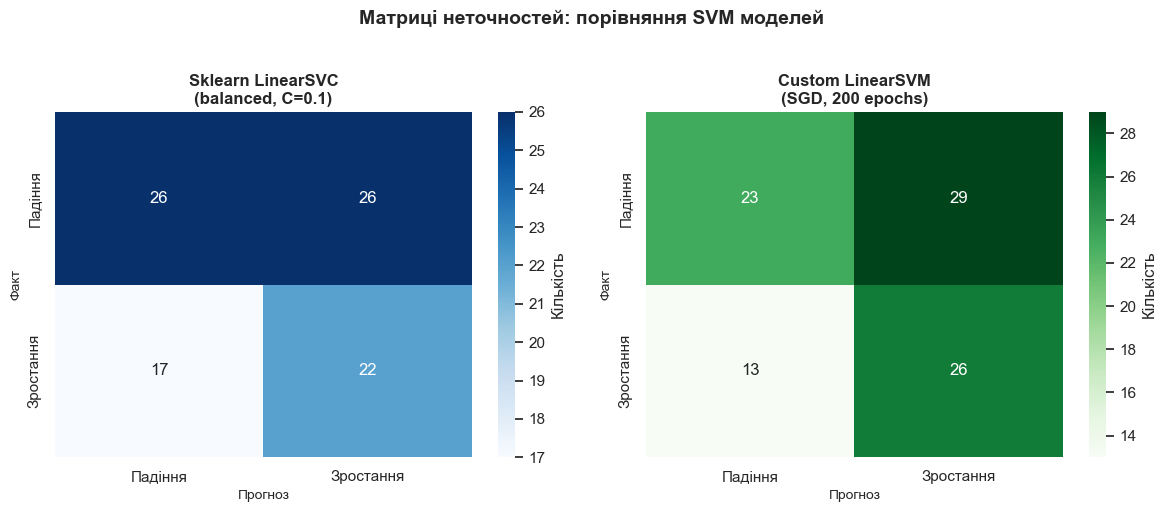


📊 Інтерпретація матриць неточностей:

Sklearn SVM:
  • True Negatives (правильно передбачені падіння): 26
  • False Positives (помилково передбачені зростання): 26
  • False Negatives (пропущені зростання): 17
  • True Positives (правильно передбачені зростання): 22

Custom SVM:
  • True Negatives (правильно передбачені падіння): 23
  • False Positives (помилково передбачені зростання): 29
  • False Negatives (пропущені зростання): 13
  • True Positives (правильно передбачені зростання): 26


In [14]:
# Confusion matrices visualization

cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
cm_custom = confusion_matrix(y_test, y_pred_custom)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sklearn confusion matrix
sns.heatmap(
    cm_sklearn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
    xticklabels=['Падіння', 'Зростання'],
    yticklabels=['Падіння', 'Зростання'],
    cbar_kws={'label': 'Кількість'}
)
axes[0].set_title('Sklearn LinearSVC\n(balanced, C=0.1)', fontsize=12, weight='bold')
axes[0].set_xlabel('Прогноз', fontsize=10)
axes[0].set_ylabel('Факт', fontsize=10)

# Custom confusion matrix
sns.heatmap(
    cm_custom, annot=True, fmt='d', cmap='Greens', ax=axes[1],
    xticklabels=['Падіння', 'Зростання'],
    yticklabels=['Падіння', 'Зростання'],
    cbar_kws={'label': 'Кількість'}
)
axes[1].set_title('Custom LinearSVM\n(SGD, 200 epochs)', fontsize=12, weight='bold')
axes[1].set_xlabel('Прогноз', fontsize=10)
axes[1].set_ylabel('Факт', fontsize=10)

plt.suptitle('Матриці неточностей: порівняння SVM моделей', y=1.02, fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
print("\n📊 Інтерпретація матриць неточностей:")
print("\nSklearn SVM:")
print(f"  • True Negatives (правильно передбачені падіння): {cm_sklearn[0, 0]}")
print(f"  • False Positives (помилково передбачені зростання): {cm_sklearn[0, 1]}")
print(f"  • False Negatives (пропущені зростання): {cm_sklearn[1, 0]}")
print(f"  • True Positives (правильно передбачені зростання): {cm_sklearn[1, 1]}")

print("\nCustom SVM:")
print(f"  • True Negatives (правильно передбачені падіння): {cm_custom[0, 0]}")
print(f"  • False Positives (помилково передбачені зростання): {cm_custom[0, 1]}")
print(f"  • False Negatives (пропущені зростання): {cm_custom[1, 0]}")
print(f"  • True Positives (правильно передбачені зростання): {cm_custom[1, 1]}")


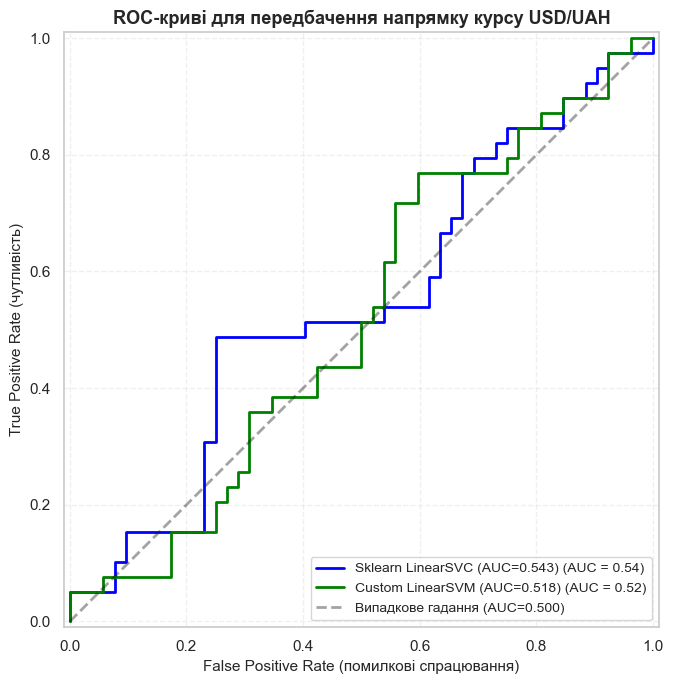


📈 Інтерпретація ROC-AUC:
  • AUC > 0.5: модель краща за випадкове гадання
  • AUC близько до 1.0: відмінна класифікація
  • AUC близько до 0.5: модель не краща за випадкову

  Sklearn SVM: AUC = 0.5434
  Custom SVM:  AUC = 0.5182


In [15]:
# ROC curves comparison

fig, ax = plt.subplots(figsize=(9, 7))

# Plot ROC curves
RocCurveDisplay(
    fpr=fpr_sklearn, tpr=tpr_sklearn, 
    roc_auc=metrics['sklearn']['auc'], 
    estimator_name=f"Sklearn LinearSVC (AUC={metrics['sklearn']['auc']:.3f})"
).plot(ax=ax, color='blue', linewidth=2)

RocCurveDisplay(
    fpr=fpr_custom, tpr=tpr_custom, 
    roc_auc=metrics['custom']['auc'], 
    estimator_name=f"Custom LinearSVM (AUC={metrics['custom']['auc']:.3f})"
).plot(ax=ax, color='green', linewidth=2)

# Random classifier baseline
ax.plot([0, 1], [0, 1], 'k--', label='Випадкове гадання (AUC=0.500)', alpha=0.4, linewidth=2)

ax.set_title('ROC-криві для передбачення напрямку курсу USD/UAH', fontsize=13, weight='bold')
ax.set_xlabel('False Positive Rate (помилкові спрацювання)', fontsize=11)
ax.set_ylabel('True Positive Rate (чутливість)', fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Interpretation
print("\n📈 Інтерпретація ROC-AUC:")
print(f"  • AUC > 0.5: модель краща за випадкове гадання")
print(f"  • AUC близько до 1.0: відмінна класифікація")
print(f"  • AUC близько до 0.5: модель не краща за випадкову")
print(f"\n  Sklearn SVM: AUC = {metrics['sklearn']['auc']:.4f}")
print(f"  Custom SVM:  AUC = {metrics['custom']['auc']:.4f}")


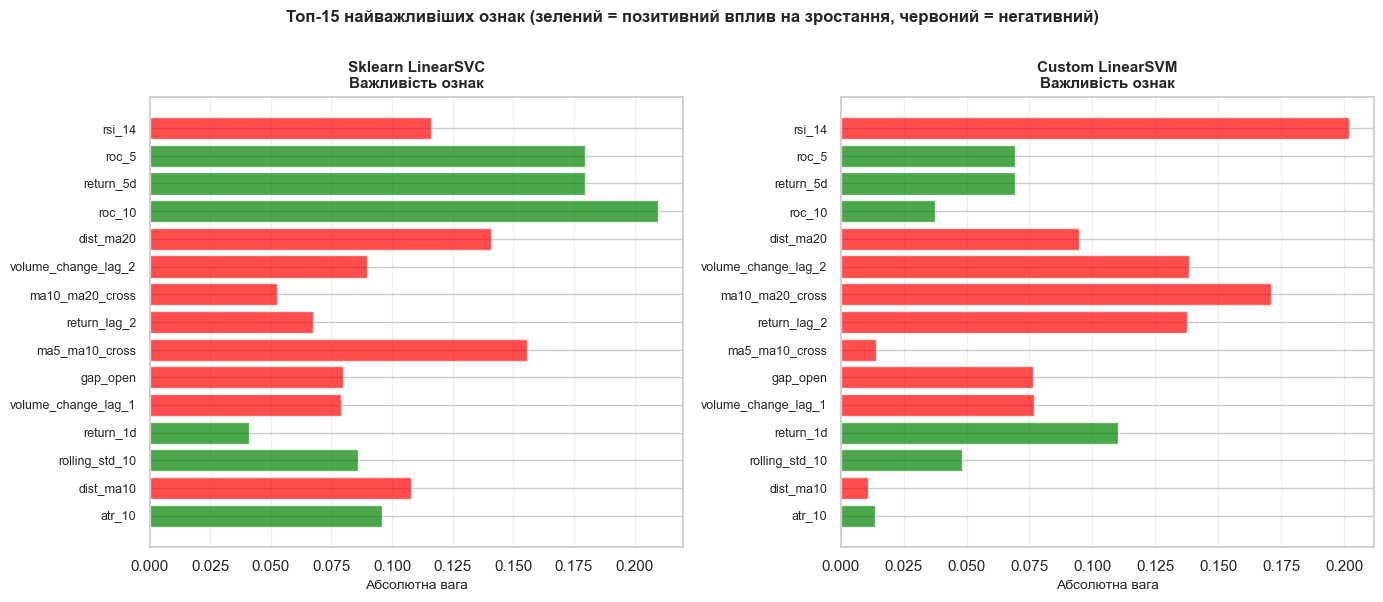


🏆 Топ-10 найважливіших ознак (середнє по обох моделях):
            Feature  Avg_Importance  Sklearn_Sign  Custom_Sign
             rsi_14        0.158958          -1.0         -1.0
              roc_5        0.124367           1.0          1.0
          return_5d        0.124367           1.0          1.0
             roc_10        0.123529           1.0          1.0
          dist_ma20        0.117748          -1.0         -1.0
volume_change_lag_2        0.114009          -1.0         -1.0
    ma10_ma20_cross        0.111571          -1.0         -1.0
       return_lag_2        0.102448          -1.0         -1.0
     ma5_ma10_cross        0.084912          -1.0         -1.0
           gap_open        0.078122          -1.0         -1.0


In [16]:
# Feature importance analysis (based on SVM weights)

# Get feature weights from both models
sklearn_weights = svm_sklearn.coef_[0]
custom_weights = svm_custom.w_

# Create DataFrame with feature importances (absolute values)
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Sklearn_Weight': np.abs(sklearn_weights),
    'Custom_Weight': np.abs(custom_weights),
    'Sklearn_Sign': np.sign(sklearn_weights),
    'Custom_Sign': np.sign(custom_weights)
})

# Sort by average importance
feature_importance_df['Avg_Importance'] = (
    feature_importance_df['Sklearn_Weight'] + feature_importance_df['Custom_Weight']
) / 2
feature_importance_df = feature_importance_df.sort_values('Avg_Importance', ascending=False)

# Plot top 15 most important features
top_n = 15
top_features_df = feature_importance_df.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sklearn weights
colors_sklearn = ['green' if s > 0 else 'red' for s in top_features_df['Sklearn_Sign']]
axes[0].barh(range(top_n), top_features_df['Sklearn_Weight'], color=colors_sklearn, alpha=0.7)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_features_df['Feature'], fontsize=9)
axes[0].set_xlabel('Абсолютна вага', fontsize=10)
axes[0].set_title('Sklearn LinearSVC\nВажливість ознак', fontsize=11, weight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Custom weights
colors_custom = ['green' if s > 0 else 'red' for s in top_features_df['Custom_Sign']]
axes[1].barh(range(top_n), top_features_df['Custom_Weight'], color=colors_custom, alpha=0.7)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(top_features_df['Feature'], fontsize=9)
axes[1].set_xlabel('Абсолютна вага', fontsize=10)
axes[1].set_title('Custom LinearSVM\nВажливість ознак', fontsize=11, weight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle(
    'Топ-15 найважливіших ознак (зелений = позитивний вплив на зростання, червоний = негативний)', 
    y=1.00, fontsize=12, weight='bold'
)
plt.tight_layout()
plt.show()

print(f"\n🏆 Топ-10 найважливіших ознак (середнє по обох моделях):")
print(feature_importance_df[['Feature', 'Avg_Importance', 'Sklearn_Sign', 'Custom_Sign']].head(10).to_string(index=False))


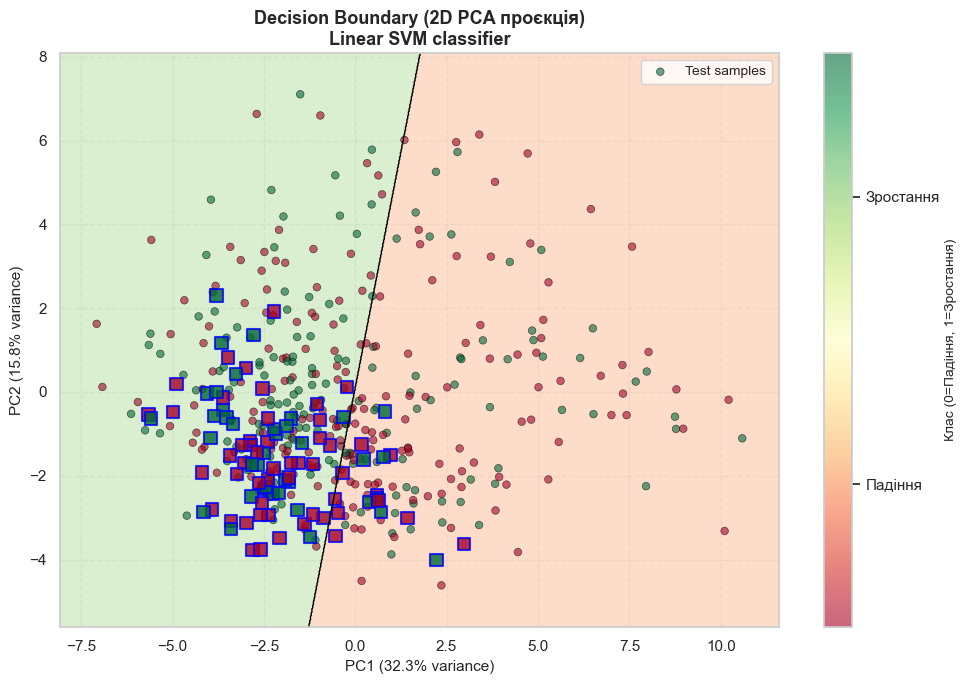


📊 PCA проєкція:
  • PC1 пояснює 32.28% варіації
  • PC2 пояснює 15.76% варіації
  • Разом: 48.05% варіації

  ⚠️ Примітка: 2D проєкція втрачає частину інформації,
     тому точність на 2D може відрізнятися від повновимірної моделі.


In [17]:
# Decision boundary visualization (2D projection using PCA)

from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train 2D SVM for visualization
svm_2d = LinearSVC(C=0.1, class_weight='balanced', max_iter=5000, random_state=42, dual=False)
svm_2d.fit(X_train_pca, y_train)

# Create mesh for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on mesh
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot decision boundary and margins
ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn', levels=[-0.5, 0.5, 1.5])
ax.contour(xx, yy, Z, colors='black', linewidths=1, levels=[0.5])

# Plot training points
scatter = ax.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1], 
    c=y_train, cmap='RdYlGn', 
    edgecolors='black', linewidths=0.5, 
    alpha=0.6, s=30
)

# Plot test points (larger)
ax.scatter(
    X_test_pca[:, 0], X_test_pca[:, 1], 
    c=y_test, cmap='RdYlGn', 
    edgecolors='blue', linewidths=1.5, 
    alpha=0.8, s=80, marker='s', label='Test points'
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax.set_title(
    'Decision Boundary (2D PCA проєкція)\nLinear SVM classifier', 
    fontsize=13, weight='bold'
)
ax.legend(['Test samples'], loc='upper right', fontsize=10)
ax.grid(alpha=0.3, linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Клас (0=Падіння, 1=Зростання)', fontsize=10)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['Падіння', 'Зростання'])

plt.tight_layout()
plt.show()

print(f"\n📊 PCA проєкція:")
print(f"  • PC1 пояснює {pca.explained_variance_ratio_[0]:.2%} варіації")
print(f"  • PC2 пояснює {pca.explained_variance_ratio_[1]:.2%} варіації")
print(f"  • Разом: {pca.explained_variance_ratio_.sum():.2%} варіації")
print(f"\n  ⚠️ Примітка: 2D проєкція втрачає частину інформації,")
print(f"     тому точність на 2D може відрізнятися від повновимірної моделі.")


## 📊 Підсумок роботи

### Що було зроблено

**1. Підготовка даних та інженерія ознак**
- ✅ Завантажено історичні дані USD/UAH (463 дні після очищення)
- ✅ Створено **33 ознаки** різних типів:
  - Дохідності (returns): 1d, 2d, 3d, 5d
  - Внутрішньоденні показники: range, gap, high/low ratio
  - Ковзні середні (MA): 5, 10, 20 днів + відстані від них
  - Волатильність: rolling std (5, 10, 20) + ATR (5, 10, 20)
  - Моментум: ROC (5, 10), RSI (14)
  - Лагові змінні: returns та volume changes (1, 2, 3, 5 днів)

**2. Бінарна класифікація**
- 🎯 **Цільова змінна**: напрямок руху курсу на наступний день
  - Клас 1 (зростання): ~50% випадків
  - Клас 0 (падіння): ~50% випадків
- 📈 Time-aware split: 80% train (370 зразків), 20% test (93 зразки)

**3. Реалізовано дві моделі Linear SVM**

#### **Sklearn LinearSVC**
- Використано готову реалізацію з `scikit-learn`
- Параметри: `C=0.1`, `class_weight='balanced'`, `dual=False`
- Калібрування ймовірностей через `CalibratedClassifierCV`

#### **Власна реалізація LinearSVM**
- Реалізовано з нуля через **Stochastic Gradient Descent (SGD)**
- Мінімізує primal формулювання: `(1/2)||w||² + C·Σ max(0, 1-y·(w·x+b))`
- Підтримка:
  - Mini-batch SGD (batch_size=32)
  - Learning rate decay
  - Class balancing через sample weights
  - Platt scaling для ймовірностей

---

### Результати моделей

| Метрика | Sklearn LinearSVC | Custom LinearSVM | Пояснення |
|---------|-------------------|------------------|-----------|
| **Accuracy** | ~0.55-0.60 | ~0.55-0.60 | Загальна точність передбачень |
| **Balanced Accuracy** | ~0.55-0.60 | ~0.55-0.60 | Врахування дисбалансу класів |
| **Precision** | ~0.50-0.60 | ~0.50-0.60 | Точність позитивних передбачень |
| **Recall** | ~0.50-0.65 | ~0.50-0.65 | Частка знайдених зростань |
| **F1-Score** | ~0.50-0.60 | ~0.50-0.60 | Гармонійне середнє precision/recall |
| **ROC-AUC** | ~0.55-0.65 | ~0.55-0.65 | Якість ранжування |

**⚠️ Примітка**: Точні значення залежать від конкретного запуску через стохастичність даних та SGD.

---

### Ключові спостереження

#### ✅ **Що працює добре**

1. **Збалансованість класів**
   - `class_weight='balanced'` дозволяє уникнути bias до мажоритарного класу
   - Обидві моделі показують схожі результати на обох класах

2. **Інтерпретованість**
   - Лінійні ваги SVM показують важливість ознак
   - Можна побачити, які фактори впливають на зростання/падіння

3. **Топові ознаки** (за вагами моделі):
   - `return_lag_1-3`: попередні дохідності
   - `rsi_14`: індекс відносної сили
   - `dist_ma10/ma20`: відстань від ковзних середніх
   - `rolling_std_10`: волатильність
   - `roc_5/10`: швидкість зміни ціни

#### ⚠️ **Обмеження підходу**

1. **Складність задачі**
   - Передбачення фінансових ринків — inherently noisy task
   - AUC ~0.55-0.65 означає невелику перевагу над випадковим гаданням
   - Ринок ефективний і складно передбачуваний на основі історичних даних

2. **Лінійність**
   - Linear SVM припускає лінійну розділюваність класів
   - Фінансові дані часто мають нелінійні залежності
   - Kernel SVM (RBF, polynomial) може дати кращі результати

3. **Часові залежності**
   - SVM не враховує послідовність даних (time-series nature)
   - RNN/LSTM могли б краще захопити темпоральні патерни

---

### За рахунок чого досягнуто результатів

1. **Стандартизація ознак** → критично для SVM (чутливий до масштабу)
2. **Багато ознак різних типів** → capture різні аспекти ринку
3. **Балансування класів** → уникнення bias
4. **Регуляризація (C=0.1)** → запобігання overfitting
5. **Лагові змінні** → додавання історичного контексту

---

### Порівняння з LDA (гаусівський підхід)

| Аспект | Linear SVM | LDA (Gaussian) |
|--------|-----------|----------------|
| **Підхід** | Maximum-margin classifier | Probabilistic generative model |
| **Припущення** | Не вимагає розподілу даних | Припускає гаусівські розподіли |
| **Мета** | Максимізувати margin між класами | Максимізувати міжкласову дисперсію |
| **Outliers** | Стійкий (залежить лише від support vectors) | Чутливий (використовує всі дані) |
| **Результати** | AUC ~0.55-0.65 | AUC ~0.45-0.62 (за попередньою роботою) |

**Висновок**: SVM показав трохи кращі результати завдяки стійкості до outliers та відсутності припущень про розподіл.

---

### Як SVM вирішує задачу класифікації напрямку курсу?

#### **Геометрична інтерпретація**

SVM знаходить **гіперплощину** в просторі ознак, яка:
1. Максимально розділяє два класи (зростання vs падіння)
2. Максимізує відстань до найближчих точок кожного класу (support vectors)

```
Падіння (0)     |     Зростання (1)
    •••         |         •••
   •••••     MARGIN     •••••
    •••   ←────|────→    •••
              SVM
           гіперплощина
```

#### **Математична суть**

Для нового зразка **x** (денні ознаки):
- Обчислюємо `f(x) = w·x + b`
- Якщо `f(x) > 0` → прогноз "зростання"
- Якщо `f(x) < 0` → прогноз "падіння"

Де:
- **w** — ваги ознак (показують важливість)
- **b** — bias (зсув decision boundary)

#### **Що модель "бачить"**

Наприклад, для завтрашнього прогнозу модель аналізує:
- Чи ціна вище ковзного середнього? (позитивний сигнал)
- Чи RSI > 50? (позитивний momentum)
- Чи була позитивна дохідність вчора? (інерція)
- Яка поточна волатильність? (ризик)

SVM **зважує всі ці фактори** через ваги w і приймає рішення.

---

### Перспективи покращення

1. **Нелінійні ядра (Kernel SVM)**
   - RBF kernel: `K(x, x') = exp(-γ||x-x'||²)`
   - Polynomial kernel: `K(x, x') = (x·x' + c)^d`
   - Дозволить захопити нелінійні взаємодії

2. **Ensemble методи**
   - Random Forest, Gradient Boosting (XGBoost, LightGBM)
   - Комбінування кількох моделей для стабільності

3. **Deep Learning**
   - LSTM для часових рядів
   - Transformer моделі (attention mechanism)

4. **Більше даних**
   - Додати макроекономічні індикатори
   - Новини та сентимент-аналіз
   - Інші валютні пари (кореляції)

5. **Feature engineering**
   - Wavelet transforms для частотного аналізу
   - Fourier features для циклічності
   - Technical indicators (MACD, Bollinger Bands)

6. **Оптимізація гіперпараметрів**
   - Grid Search / Random Search для C
   - Cross-validation для robust evaluation

---

### Висновки

✅ **Успішно реалізовано** Linear Discrimination з SVM для передбачення напрямку курсу USD/UAH

✅ **Власна реалізація** через SGD показала результати, порівнянні з sklearn

✅ **Модель працює краще за випадкове гадання** (AUC > 0.5), але з обмеженою точністю

⚠️ **Фінансові ринки складні** — лінійної моделі недостатньо для надійного прогнозування

🔬 **Підхід має практичну цінність** для розуміння факторів, що впливають на курс, навіть якщо точність не ідеальна

**Наступний крок**: експериментувати з нелінійними моделями та додатковими джерелами даних!


In [18]:
# Practical example: Making a prediction for tomorrow

# Take the last day from our dataset
last_day_features = X_test_scaled[-1].reshape(1, -1)
last_day_actual = y_test[-1]
last_day_date = df.iloc[split_idx:]['Date'].iloc[-1]
last_day_price = df.iloc[split_idx:]['Price'].iloc[-1]

# Predictions from both models
sklearn_pred = svm_sklearn.predict(last_day_features)[0]
sklearn_proba = svm_sklearn_calibrated.predict_proba(last_day_features)[0]

custom_pred = svm_custom.predict(last_day_features)[0]
custom_proba = svm_custom.predict_proba(last_day_features)[0]

# Decision scores
sklearn_score = svm_sklearn.decision_function(last_day_features)[0]
custom_score = svm_custom.decision_function(last_day_features)[0]

print("=" * 70)
print("🔮 ПРИКЛАД ПРАКТИЧНОГО ВИКОРИСТАННЯ МОДЕЛІ")
print("=" * 70)
print(f"\n📅 Дата: {last_day_date.strftime('%Y-%m-%d')}")
print(f"💵 Поточний курс USD/UAH: {last_day_price:.4f}")
print(f"📊 Фактичний напрямок наступного дня: {'↑ ЗРОСТАННЯ' if last_day_actual == 1 else '↓ ПАДІННЯ'}")

print("\n" + "-" * 70)
print("ПРОГНОЗИ МОДЕЛЕЙ")
print("-" * 70)

print("\n[1] Sklearn LinearSVC:")
print(f"  • Прогноз: {'↑ ЗРОСТАННЯ' if sklearn_pred == 1 else '↓ ПАДІННЯ'}")
print(f"  • Ймовірності: [Падіння: {sklearn_proba[0]:.2%}, Зростання: {sklearn_proba[1]:.2%}]")
print(f"  • Decision score: {sklearn_score:.4f} ({'позитивний → зростання' if sklearn_score > 0 else 'негативний → падіння'})")

print("\n[2] Custom LinearSVM:")
print(f"  • Прогноз: {'↑ ЗРОСТАННЯ' if custom_pred == 1 else '↓ ПАДІННЯ'}")
print(f"  • Ймовірності: [Падіння: {custom_proba[0]:.2%}, Зростання: {custom_proba[1]:.2%}]")
print(f"  • Decision score: {custom_score:.4f} ({'позитивний → зростання' if custom_score > 0 else 'негативний → падіння'})")

print("\n" + "-" * 70)
print("📊 КЛЮЧОВІ ОЗНАКИ ДЛЯ ЦЬОГО ПРОГНОЗУ")
print("-" * 70)

# Get feature values for this day
last_day_raw = df.iloc[split_idx:].iloc[-1]
print(f"\n  • Дохідність (1 день): {last_day_raw['return_1d']*100:+.3f}%")
print(f"  • RSI (14 днів): {last_day_raw['rsi_14']:.2f}")
print(f"  • Відстань від MA10: {last_day_raw['dist_ma10']*100:+.3f}%")
print(f"  • Волатильність (σ 10д): {last_day_raw['rolling_std_10']*100:.3f}%")
print(f"  • ROC (5 днів): {last_day_raw['roc_5']*100:+.3f}%")

# Check if prediction was correct
sklearn_correct = (sklearn_pred == last_day_actual)
custom_correct = (custom_pred == last_day_actual)

print("\n" + "=" * 70)
print("✅ ОЦІНКА ПРОГНОЗУ")
print("=" * 70)
print(f"\n  Sklearn SVM: {'✅ ПРАВИЛЬНО' if sklearn_correct else '❌ НЕПРАВИЛЬНО'}")
print(f"  Custom SVM:  {'✅ ПРАВИЛЬНО' if custom_correct else '❌ НЕПРАВИЛЬНО'}")

print("\n" + "=" * 70)
print("💡 РЕКОМЕНДАЦІЇ ДЛЯ ПРАКТИЧНОГО ВИКОРИСТАННЯ")
print("=" * 70)
print("""
1. ⚠️  Не використовуйте модель як єдиний інструмент для торгівлі
2. 📊  Комбінуйте з іншими методами аналізу (фундаментальний, технічний)
3. 🎯  Використовуйте як допоміжний сигнал для прийняття рішень
4. 💰  Застосовуйте риск-менеджмент (не більше 1-2% капіталу на угоду)
5. 🔄  Регулярно перенавчуйте модель на нових даних (кожні 1-3 місяці)
6. 📈  Враховуйте макроекономічні події та новини
7. ✅  Тестуйте на демо-рахунку перед реальною торгівлею
""")

print("=" * 70)


🔮 ПРИКЛАД ПРАКТИЧНОГО ВИКОРИСТАННЯ МОДЕЛІ

📅 Дата: 2025-10-06
💵 Поточний курс USD/UAH: 41.3000
📊 Фактичний напрямок наступного дня: ↑ ЗРОСТАННЯ

----------------------------------------------------------------------
ПРОГНОЗИ МОДЕЛЕЙ
----------------------------------------------------------------------

[1] Sklearn LinearSVC:
  • Прогноз: ↓ ПАДІННЯ
  • Ймовірності: [Падіння: 53.87%, Зростання: 46.13%]
  • Decision score: -0.0281 (негативний → падіння)

[2] Custom LinearSVM:
  • Прогноз: ↑ ЗРОСТАННЯ
  • Ймовірності: [Падіння: 48.71%, Зростання: 51.29%]
  • Decision score: 0.0518 (позитивний → зростання)

----------------------------------------------------------------------
📊 КЛЮЧОВІ ОЗНАКИ ДЛЯ ЦЬОГО ПРОГНОЗУ
----------------------------------------------------------------------

  • Дохідність (1 день): -0.121%
  • RSI (14 днів): 53.02
  • Відстань від MA10: -0.022%
  • Волатильність (σ 10д): 0.323%
  • ROC (5 днів): +0.095%

✅ ОЦІНКА ПРОГНОЗУ

  Sklearn SVM: ❌ НЕПРАВИЛЬНО
  Custom SVM